In [1]:
!pip install adversarial-robustness-toolbox==1.13.0

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Import required libraries for TensorFlow 1.x
import tensorflow.compat.v1 as tf  # Use TensorFlow 1.x
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import seed

# Set the random seed
seed(123)

# Import ART classes
from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
from art.utils import load_dataset

# Disable eager execution in TensorFlow 1.x
tf.disable_eager_execution()

# Read MNIST dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset('mnist')

# Define CNN model wrapped with ART KerasClassifier
def cnn_mnist(input_shape, min_val, max_val):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    classifier = KerasClassifier(clip_values=(min_val, max_val), 
                                 model=model, use_logits=False)
    return classifier

# Train the model
num_epochs = 10
classifier = cnn_mnist(x_train.shape[1:], min_, max_)
classifier.fit(x_train, y_train, nb_epochs=num_epochs, batch_size=128)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 74s 1ms/sample - loss: 0.2201 - accuracy: 0.9348
Epoch 2/10
60000/60000 [==============================] - 68s 1ms/sample - loss: 0.0638 - accuracy: 0.9803
Epoch 3/10
60000/60000 [==============================] - 350s 6ms/sample - loss: 0.0454 - accuracy: 0.9858
Epoch 4/10
60000/60000 [==============================] - 44s 729us/sample - loss: 0.0365 - accuracy: 0.9884
Epoch 5/10
60000/60000 [==============================] - 59s 988us/sample - loss: 0.0303 - accuracy: 0.9904
Epoch 6/10
60000/60000 [==============================] - 61s 1ms/sample - loss: 0.0262 - accuracy: 0.9914
Epoch 7/10
60000/60000 [==============================] - 64s 1ms/sample - loss: 0.0216 - accuracy: 0.9932
Epoch 8/10
60000/60000 [==============================] - 67s 1ms/sample - loss: 0.0179 - accuracy: 0.9941
Epoch 9/10
60000/60000 [==============================] - 430s 7ms/sample - loss: 0.0178 - accuracy: 0.9937
Epoch 10

In [4]:
attack = MIFace(classifier, max_iter=10000, threshold=1.)

# Target classes (0 to 9 for MNIST)
y = np.arange(10)


In [5]:
x_init_white = np.zeros((10, 28, 28, 1))
x_init_grey = np.zeros((10, 28, 28, 1)) + 0.5
x_init_black = np.ones((10, 28, 28, 1))
x_init_random = np.random.uniform(0, 1, (10, 28, 28, 1))
x_init_average = np.zeros((10, 28, 28, 1)) + np.mean(x_test, axis=0)

Maximum class gradient (white): 0.046861


Model inversion: 100%|██████████| 10/10 [13:30<00:00, 81.00s/it]


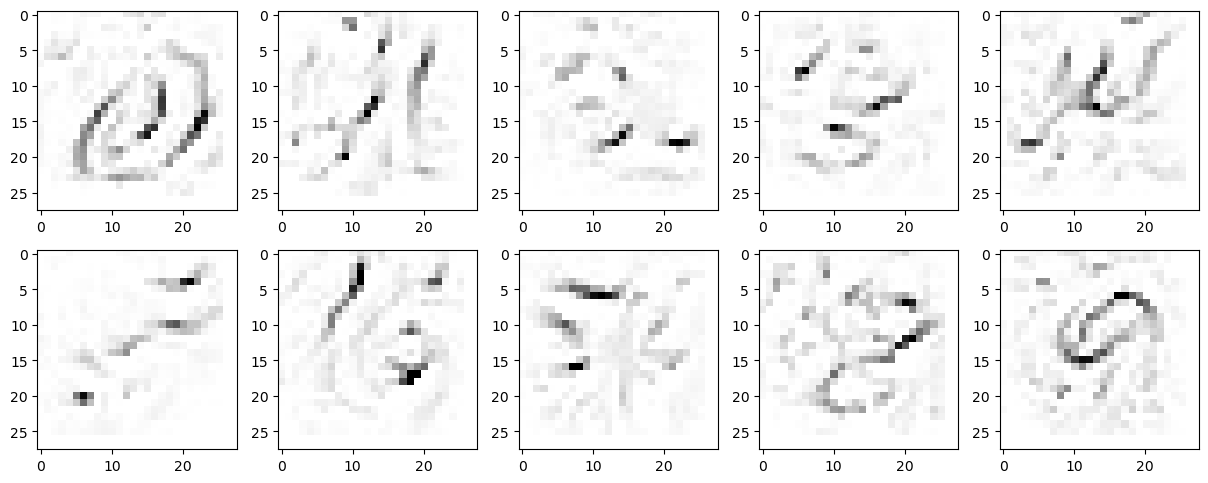

In [6]:
print("Maximum class gradient (white): %f" % (np.max(np.abs(classifier.class_gradient(x_init_white, y)))))
# Run the attack
x_infer_from_white = attack.infer(x_init_white, y)
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(x_infer_from_white[i], (28, 28)), cmap=plt.cm.gray_r)


Minimum over all maximum class gradient (grey): 0.007176


Model inversion: 100%|██████████| 10/10 [12:00<00:00, 72.06s/it]


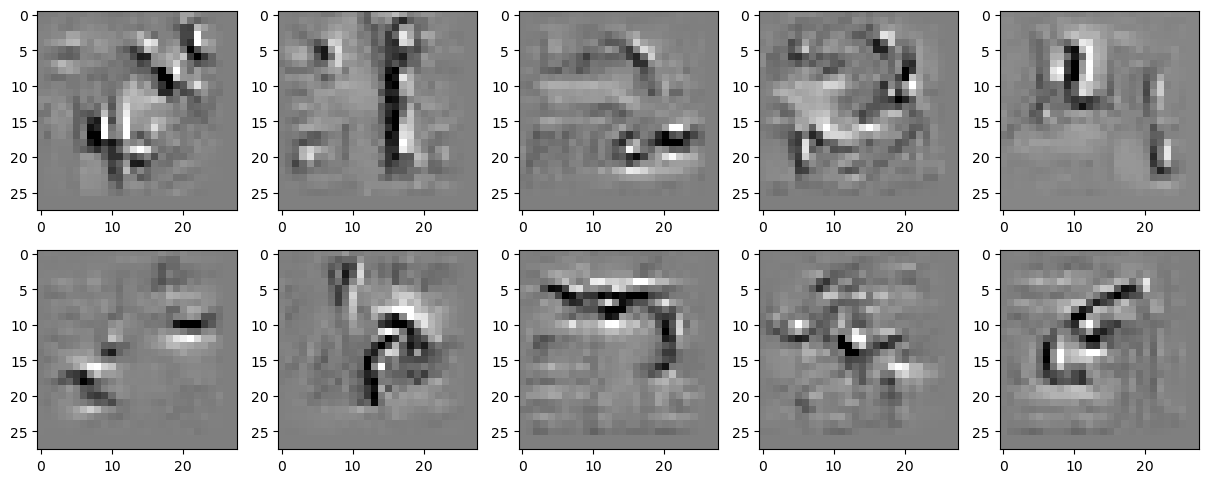

In [7]:
class_gradient = classifier.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient (grey): %f" % (np.min(class_gradient_max)))
x_infer_from_grey = attack.infer(x_init_grey, y)
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(x_infer_from_grey[i], (28, 28)), cmap=plt.cm.gray_r)


Minimum over all maximum class gradient (black): 0.002801


Model inversion: 100%|██████████| 10/10 [10:21<00:00, 62.10s/it]


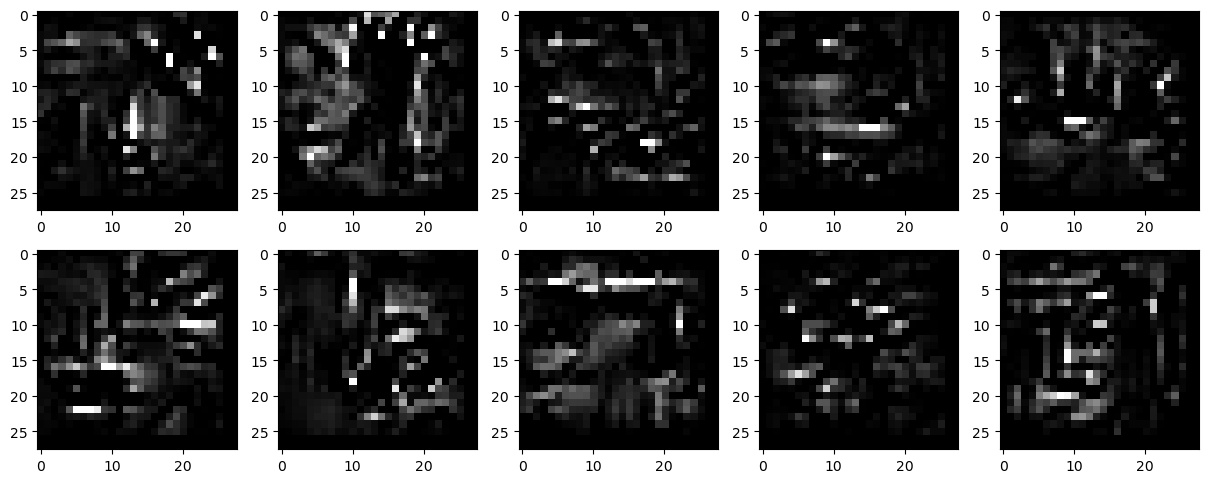

In [8]:
# Initialization with black image (Gradients may still be non-zero)
class_gradient = classifier.class_gradient(x_init_black, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient (black): %f" % (np.min(class_gradient_max)))
x_infer_from_black = attack.infer(x_init_black, y)
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(x_infer_from_black[i], (28, 28)), cmap=plt.cm.gray_r)


Minimum over all maximum class gradient (random): 0.002330


Model inversion: 100%|██████████| 10/10 [06:21<00:00, 38.15s/it]


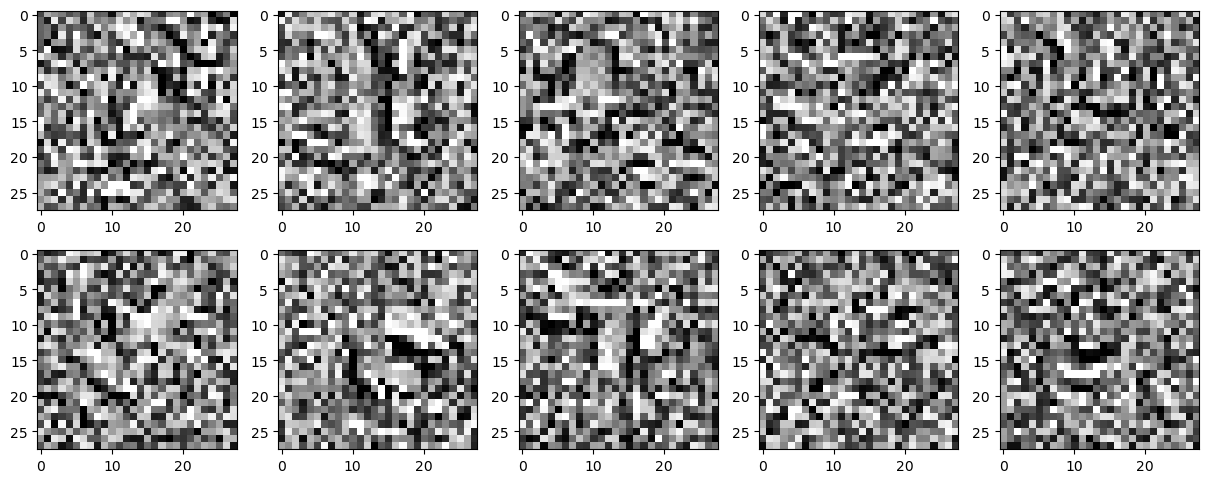

In [9]:

# Initialization with random image (Gradients should be reasonable)
class_gradient = classifier.class_gradient(x_init_random, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient (random): %f" % (np.min(class_gradient_max)))
x_infer_from_random = attack.infer(x_init_random, y)
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(x_infer_from_random[i], (28, 28)), cmap=plt.cm.gray_r)

Minimum over all maximum class gradient (average): 0.012338


Model inversion: 100%|██████████| 10/10 [04:00<00:00, 24.08s/it]


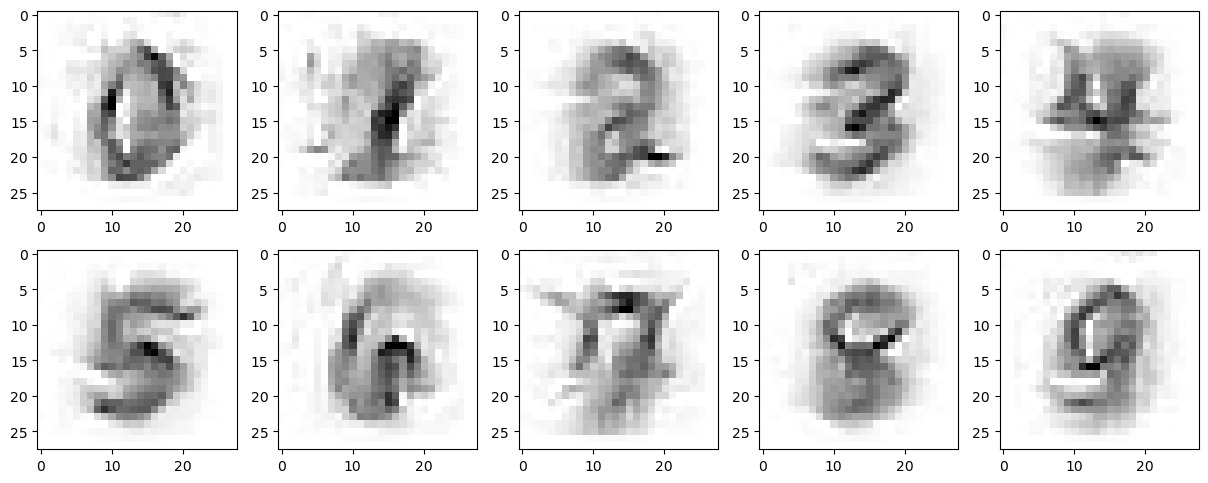

In [10]:

# Initialization with average image (Reasonable gradients)
class_gradient = classifier.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (10, 28*28))
class_gradient_max = np.max(class_gradient, axis=1)
print("Minimum over all maximum class gradient (average): %f" % (np.min(class_gradient_max)))
x_infer_from_average = attack.infer(x_init_average, y)
plt.figure(figsize=(15,15))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(np.reshape(x_infer_from_average[i], (28, 28)), cmap=plt.cm.gray_r)